In [1]:
# 모델.py + mrr 측정 함수 + loss 함수 수정 + train, valid 수정

In [2]:
import random
import math
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from transformers import AutoTokenizer, AutoModel
from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model, TaskType #, AdapterConfig

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)            # 기본 Python random 고정
    np.random.seed(seed)         # NumPy 랜덤 고정
    torch.manual_seed(seed)      # CPU 연산 랜덤 고정
    torch.cuda.manual_seed(seed) # GPU 모든 디바이스 랜덤 고정
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU일 때

    # 연산 재현성
    torch.backends.cudnn.deterministic = True  # cuDNN 연산을 determinisitc으로 강제
    torch.backends.cudnn.benchmark = False     # CUDA 성능 자동 튜닝 기능 끔 → 완전 재현 가능

set_seed(42)

In [4]:
EPOCHS = 20
WARMUP_RATIO = 0.1
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
TEMPERATURE = 0.05
NEG_RATIO = 0.2

In [5]:
class E5LoRABackbone(nn.Module):
    def __init__(self, model_name: str, lora_cfg: dict):
        super().__init__()
        
        base_model = AutoModel.from_pretrained(model_name)

        # Linear(d → d) -→ Linear(d → d) + LoRA(d → d)
        lora_config = LoraConfig( 
            task_type=TaskType.FEATURE_EXTRACTION, # 임베딩 fine-tuning
            # LoRA가 분류기와 같은 output head에 적용되는 것이 아니라
            # 모델의 Transformer 블록(encoder)에만 적용되도록
            r=lora_cfg["r"],    # LoRA rank
            lora_alpha=lora_cfg["alpha"],
            lora_dropout=lora_cfg["dropout"],
            bias="none"
        )

        self.encoder = get_peft_model(base_model, lora_config)
        self.config = self.encoder.config # hidden_size 같은거 head에서 알아야함
    
    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        # return outputs.last_hidden_state[:, 0] single vector 테스트할땐 일케 했는디..
        return outputs.last_hidden_state # head에 넣을거라 CLS pooling 안함

In [6]:
class SimpleMultiVectorHead(nn.Module):
    def __init__(self, num_vectors=3,  input_dim=384):
        super().__init__()

        # k개의 학습 가능한 쿼리 토큰 생성
        self.query_tokens = nn.Parameter( # 일단 텐서랑 다르게 학습 가능함
            torch.randn(1, num_vectors, input_dim) # (1, K, D) 차원의 랜덤값
        )
        # nn.init.normal_(self.query_tokens, std=0.02)
        # nn.init.orthogonal_(self.query_tokens)
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(input_dim)
    
    def forward(self, seq_out, attn_mask):
        """
        # shapes
        query = queries  # (B, K, D)
        key = seq_out    # (B, L, D)
        value = seq_out  # (B, L, D)
        """
        batch_size = seq_out.shape[0] # (B)
        queries = self.query_tokens.repeat(batch_size, 1, 1)  # Query 확장 (1, K, D) -> (B, K, D)
        key_padding_mask = ~attn_mask.bool()

        vectors, _ = self.attention( # (B, K, D)
            query=queries,
            key=seq_out,
            value=seq_out,
            key_padding_mask=key_padding_mask
        )

        # 2. 🔥 [Pro Tip] 잔차 연결 (Residual) + LayerNorm
        # "새로 배운 정보(vectors)에 원래 내 자아(queries)를 섞는다"
        # 이렇게 하면 학습이 훨씬 안정적으로 변합니다.
        # vectors = self.norm(queries + vectors)
        return vectors

In [7]:
class BookEmbeddingModel(nn.Module):
    def __init__(self, model_name: str, lora_config: dict):
        super().__init__()
        self.backbone = E5LoRABackbone(model_name, lora_config)
        self.head = SimpleMultiVectorHead(num_vectors=2, input_dim=self.backbone.config.hidden_size)
    
    def forward(self, input_ids, attention_mask, **kargs):
        sequence_output = self.backbone(input_ids, attention_mask) # (B, L, D)
        embeddings = self.head(sequence_output, attention_mask) # (B, k, D)
        return F.normalize(embeddings, p=2, dim=2) # contrastive loss 계산하려면 필수

In [8]:
model_name = "intfloat/e5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

teacher_model = AutoModel.from_pretrained(model_name)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False 

lora = {'r': 16, 'alpha': 32, 'dropout': 0.1}
model = BookEmbeddingModel(model_name, lora)
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher_model.to(device)
model.to(device)

BookEmbeddingModel(
  (backbone): E5LoRABackbone(
    (encoder): PeftModelForFeatureExtraction(
      (base_model): LoraModel(
        (model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 384, padding_idx=0)
            (position_embeddings): Embedding(512, 384)
            (token_type_embeddings): Embedding(2, 384)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=384, out_features=384, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
               

In [9]:
# book_path = './data/e5_book_meta.parquet'
book_path = './test/book_meta.parquet'
books = pd.read_parquet(book_path)

In [10]:
def build_text(row): # 입력 텍스트 생성 (타이틀 + 설명 + 저자 등 결합)
    parts = [
        f"Title: {row['title']} |",
        # f"Category: {row['category']} |", # oracle
        f"Description: {row['description']}"
    ]
    return " ".join( # 리스트의 문자열들을 공백으로 연결할건데.....
        [p for p in parts if isinstance(p, str)] # NaN이나 None이 있으면 제외함
    ) # 최종적으로 하나의 문장 형태로 반환한다고 함!! "Title: ... Category: ... Description: ..."

books["text"] = books.apply(build_text, axis=1) # 새 컬럼 text에 대해서.... 문장 만듦

# 100개 미만인 카테고리는 노이즈로 간주하고 삭제
counts = books['category'].value_counts()
valid_categories = counts[counts > 100].index
books = books[books['category'].isin(valid_categories)]

In [11]:
dataset = Dataset.from_pandas(books)

le = LabelEncoder()
le.fit(dataset['category'])   # 전체 데이터로 학습

def encode_label(x):
    return {"label": le.transform([x["category"]])[0]}

dataset = dataset.map(encode_label)

num_classes = len(le.classes_)

Map:   0%|          | 0/81845 [00:00<?, ? examples/s]

collate_fn은 raw text와 label을 텐서로 묶어 모델이 학습할 수 있는 형태로 만들어줌
DataLoader는 이 함수로 미리 전처리한 batch를 모델에 공급하는 역할을 함
```
Dataset row(dict)
     ↓ (DataLoader)
batch = [row1, row2, ...] (list)
     ↓ (collate_fn)
텍스트 리스트 + 라벨 리스트
     ↓ (tokenizer)
input_ids, attention_mask (tensor)
     ↓
(inputs, labels)
     ↓
model(**inputs)
```

In [12]:
# Transformer 모델은 이런 raw 텍스트를 바로 처리 못 하고
# 토크나이저를 거쳐 tensor(batch_input_ids, batch_attention_mask) 형태가 필요함.
def collate_fn(batch): # DataLoader가 batch마다 호출
    # texts = [f"passage: {x['text']}" for x in batch]
    texts = [f"query: {x['text']}" for x in batch]
    labels = torch.tensor([x['label'] for x in batch])  # 라벨을 int 리스트 → torch.tensor 로 변환

    """
    토크나이저:
    텍스트를 token id로 변환 (input_ids), attention_mask 생성,
    batch의 최대 length에 맞춰 패딩, 출력 타입은 PyTorch tensor

    { 'input_ids': tensor([[101,  ... , 102], ...]),
      'attention_mask': tensor([[1,1,1,0,0...], ...) }
    """
    inputs = tokenizer(
      texts, padding=True, truncation=True, max_length=256, return_tensors="pt")

    return inputs, labels

In [13]:
total_len = len(dataset)
train_len = int(total_len * 0.8)
valid_len = total_len - train_len

train_dataset, valid_dataset = random_split(dataset, [train_len, valid_len])

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

지금의 구조는 contrastive loss, genre/content KD, dynamic α, GradNorm, multi-vector head 등이 서로 얽혀 있어 LR 변화에 매우 민감함

- contrastive(genre) 비중이 큰 α=0.8 상태
- genre/content 양방향 KD 압력
- multi-vector head 정렬 전
- GradNorm 비율이 아직 수렴 안 됨
- α decay가 아직 적용 전(장르 비중 과다)

warmup을 너무 짧게(0\~2%) 주면 learning rate가 지나치게 빨리 상승해 초기 단계에서 gradient explosion이나 embedding 붕괴가 일어나고, 반대로 너무 길게(10\~20%) 주면 LR이 천천히 올라가는 동안 contrastive 쪽 표현 학습이 지연되고 embedding collapse 위험이 커져 최종 성능(MRR, top-1)까지 떨어짐

스케쥴러 자체도 바꿨는데, Linear decay는 warmup 이후에 LR이 직선으로 급격히 떨어짐. 이는 학습 후반부 KD alignment와 contrastive alignment의 미세 조정을 막아 학습이 사실상 멈추는 문제가 있음. 반면 Cosine 스케줄러는 warmup 이후 LR을 완만한 곡선 형태로 감소시키기 때문에, 초반에는 안정성을 제공하고, 중반에는 충분한 LR을 유지하며, 후반에도 작은 폭이지만 의미 있는 업데이트를 이어갈 수 있을 것임

In [14]:
total_steps = len(train_loader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# AdamW 옵티마이저로 LoRA 파라미터만 학습
# LoRA 덕분에 실제 업데이트되는 파라미터는 전체의 1% 정도

# scheduler = get_linear_schedule_with_warmup(
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1), # WARMUP_RATIO), 원래 linear 일때 썻던 값은데 0.1이었거든? 0.05로 줄이래
    num_training_steps=total_steps,
)

In [15]:
def calculate_mrr(final_similarity, all_labels, k=10):
    # 1. 자기 자신 제외 (유사도 행렬이 이미 만들어진 상태에서 시작)
    final_similarity.fill_diagonal_(-1e9) 

    # 2. Top-k 순위 및 라벨 획득 (기존 코드와 동일)
    _, topk_idx = final_similarity.topk(k, dim=1)
    nn_labels_topk = all_labels[topk_idx]

    # 3. 정답 순위 계산
    ranks = (nn_labels_topk == all_labels.unsqueeze(1)).float()
    reciprocal_rank = []

    for i in range(ranks.size(0)):
        pos_positions = torch.nonzero(ranks[i]).flatten()
        if len(pos_positions) == 0:
            reciprocal_rank.append(0.0)
        else:
            reciprocal_rank.append(1.0 / (pos_positions[0].item() + 1))

    return sum(reciprocal_rank) / len(reciprocal_rank)

In [16]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.05, neg_ratio=0.2):
        super().__init__()
        self.temperature = temperature
        self.neg_ratio = neg_ratio

    def forward(self, embeddings, labels):
        """
        anchor: 닻(기준점)
        pos_sim: anchor와 pos 샘플들의 유사도 벡터
        neg_sim: anchor와 neg 샘플들의 유사도 벡터
        """
        k = max(3, int(embeddings.size(0) * self.neg_ratio))

        similarity = torch.matmul(embeddings, embeddings.T) # 임배딩값 self 내적 -> 각 샘플당 유사도
        
        labels_eq = labels.unsqueeze(1) == labels.unsqueeze(0) # 브로드캐스팅
        identity_mask = torch.eye(len(labels), device=labels.device).bool() # 자기 자신 제거 mask
        pos_mask = (labels_eq & (~identity_mask)).float()
        pos_sim = similarity * pos_mask
        
        sim_for_neg = similarity.clone()
        sim_for_neg.masked_fill_(labels_eq, -1e9)

        # neg_sim = similarity[labels.unsqueeze(0) != labels.unsqueeze(1)]
        neg_sim, _ = sim_for_neg.topk(k, dim=1)

        # loss 확대: 정답(0.8/0.05=16), 오답(0.7/0.05=14) => exp(16) ≈ 8,886,110 vs exp(14) ≈ 1,202,604 7배 이상 차이남
        # => 0.1 차이도 크게 만들어 모델이 pos를 더더더 1에 가깝도록 맞춤
        pos_sim = pos_sim / self.temperature
        neg_sim = neg_sim / self.temperature

        loss = -torch.log(
            torch.exp(pos_sim).sum(dim=1) /
            (torch.exp(pos_sim).sum(dim=1) + torch.exp(neg_sim).sum(dim=1))
        ).mean()
        # sum해주는 이유는.. 한 anchor(기준 샘플)당 여러 개의 pos/neg 쌍이 존재할 수 있기 때문
        # 그림 mean은 왜 하는거지... 배치내 모든 loss를 평균 내는것임! -> 이번 배치의 loss는 0.36다~

        return loss

In [17]:
def calc_grad_norm(loss, model_layer):
    """
    특정 Loss가 특정 레이어(model_layer)의 파라미터에 가하는
    Gradient의 총량(Norm)을 계산합니다.
    """
    # 1. 해당 레이어의 파라미터만 가져옴 (requires_grad=True인 것만)
    params = [p for p in model_layer.parameters() if p.requires_grad]

    if not params:
        return 0.0

    # 2. Gradient 계산 (create_graph=False, retain_graph=True 필수!)
    # retain_graph=True: 뒤에 진짜 backward()를 또 해야 하므로 그래프를 날리면 안 됨
    grads = torch.autograd.grad(
        loss,
        params,
        retain_graph=True,
        allow_unused=True
    )

    # 3. Norm(크기) 합산 (L2 Norm)
    total_norm = 0.0
    for g in grads:
        if g is not None:
            total_norm += g.pow(2).sum().item()

    return total_norm ** 0.5

In [18]:
history = {
    "train_loss": [],
    "loss_scl": [],
    "loss_kd": [],
    "loss_orth": [],
    "lr": [],
    "val_mrr": [] # 검증 루프에서 나오는 mrr도 여기 담으면 좋습니다
}

In [19]:
t = 200  # 충돌 시작 지점
base_alpha = 0.8   # 초반: 장르(Genre) 정보를 확실히 잡음
target_alpha = 0.2 # 후반: 충돌 회피를 위해 장르 비중을 낮춤 (본문 집중)
steps_per_epoch = len(train_loader)
running_ratio = 1.0
beta = 0.95  # 관성 계수 (클수록 변화가 부드러움)
scl = SupervisedContrastiveLoss()
mrr_ratio = 0.5

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_loss_scl = 0
    train_loss_kd = 0
    train_loss_orth = 0
    
    for batch_inputs, labels in tqdm(train_loader, desc = f"Epoch: {epoch+1}"):    
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
        labels = labels.to(device)

        student_vectors = model(**batch_inputs) # 얜 head에서 attn_mask 따로 써서 mean_pooling 안해줘도 됨

        genre_vector = student_vectors[:, 0, :] # Vector 0: 장르
        content_vector = student_vectors[:, 1, :] # Vector 1: 내용

        # 1. scl loss
        # genre_vector는 이미 E5MultiVectorHead에서 정규화 했으니 ㄱㅊ
        # student_vector 자체가 이미 길이가 1인 벡터임
        loss_scl = scl(genre_vector, labels)

        # 2. kd loss
        with torch.no_grad():
            teacher_outputs = teacher_model(**batch_inputs)
            # teacher_embeddings = teacher_outputs.last_hidden_state.mean(dim=1)
            hidden = teacher_outputs.last_hidden_state # B, L, D
            mask = batch_inputs['attention_mask'].unsqueeze(-1) # B, L, 1
            teacher_embedding = (hidden * mask).sum(dim=1) / mask.sum(dim=1)

            teacher_norm = F.normalize(teacher_embedding, p=2, dim=-1)  # (B, D)
            
        content_norm = F.normalize(content_vector, p=2, dim=1)
        loss_kd = F.mse_loss(content_norm, teacher_norm)

        # 3. 직교 loss
        sim_orth = F.cosine_similarity(genre_vector, content_vector, dim=1)
        loss_orth = torch.abs(sim_orth).mean()

        # w_cont = 0.5 # SCL은 보통 값이 2.0~5.0으로 큽니다. 너무 세면 KD를 무시하니 절반으로 줄입니다.
        # # KD(MSE)는 값이 0.0x~0.1 수준으로 작습니다. 중요하므로 가중치를 둬야 하지만, AdamW가 스케일은 어느 정도 잡아줍니다.
        # w_kd = 1.0 # 1.0으로 두되, SCL 힘을 뺐으니 상대적으로 강조됩니다.
        # w_orth = 0.1 # Orthogonal은 보조 제약조건입니다. 너무 세면 학습을 방해하므로 '넛지(Nudge)' 정도만 줍니다.
        total_loss = (0.01 * loss_scl) + (1.0  * loss_kd) + (0.05 * loss_orth)

        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += total_loss.item()
        train_loss_scl = loss_scl.item()
        train_loss_kd = loss_kd.item()
        train_loss_orth = loss_orth.item()

    model.eval()
    embeddings_list_v0 = []
    embeddings_list_v1 = []
    labels_list = []
    
    with torch.no_grad():
        for batch_inputs, labels in valid_loader:
            batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
            labels = labels.to(device)

            student_vectors = model(**batch_inputs)
            genre_vector = student_vectors[:, 0, :]
            content_vector = student_vectors[:, 1, :]
                
            # MRR 계산을 위한 데이터 수집은 CPU로
            embeddings_list_v0.append(genre_vector.cpu())
            embeddings_list_v1.append(content_vector.cpu())
            labels_list.append(labels.cpu()) # CPU로 이동
            
    # 데이터 합치기
    all_embeddings_v0 = torch.cat(embeddings_list_v0, dim=0)
    all_embeddings_v1 = torch.cat(embeddings_list_v1, dim=0)
    all_labels = torch.cat(labels_list, dim=0)

    # 유사도 계산 (기존 코드와 동일)
    similarity_v0 = torch.matmul(all_embeddings_v0, all_embeddings_v0.T)
    similarity_v1 = torch.matmul(all_embeddings_v1, all_embeddings_v1.T)
    final_similarity = (mrr_ratio * similarity_v0) + ((1 - mrr_ratio) * similarity_v1)
    
    # MRR 계산 (유틸리티 함수 호출)
    avg_mrr = calculate_mrr(final_similarity, all_labels, k=10)

    print(f"[Epoch {epoch + 1}] Train Loss: {train_loss / len(train_loader):.4f} | mrr: {avg_mrr:.4f}" )
    
    history["train_loss"].append(train_loss / len(train_loader))
    history["loss_scl"].append(train_loss_scl / len(train_loader))
    history["loss_kd"].append(train_loss_kd / len(train_loader))
    history["loss_orth"].append(train_loss_orth / len(train_loader))

Epoch: 1: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.65it/s]


[Epoch 1] Train Loss: 0.0348 | mrr: 0.6724


Epoch: 2: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.64it/s]


[Epoch 2] Train Loss: 0.0222 | mrr: 0.6834


Epoch: 3: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 3] Train Loss: 0.0211 | mrr: 0.6825


Epoch: 4: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:21<00:00,  3.63it/s]


[Epoch 4] Train Loss: 0.0200 | mrr: 0.6887


Epoch: 5: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 5] Train Loss: 0.0193 | mrr: 0.6877


Epoch: 6: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 6] Train Loss: 0.0188 | mrr: 0.6921


Epoch: 7: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 7] Train Loss: 0.0182 | mrr: 0.6877


Epoch: 8: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 8] Train Loss: 0.0179 | mrr: 0.6907


Epoch: 9: 100%|██████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.64it/s]


[Epoch 9] Train Loss: 0.0174 | mrr: 0.6919


Epoch: 10: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:21<00:00,  3.63it/s]


[Epoch 10] Train Loss: 0.0170 | mrr: 0.6946


Epoch: 11: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 11] Train Loss: 0.0140 | mrr: 0.6608


Epoch: 12: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 12] Train Loss: 0.0102 | mrr: 0.6675


Epoch: 13: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 13] Train Loss: 0.0090 | mrr: 0.6665


Epoch: 14: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 14] Train Loss: 0.0084 | mrr: 0.6681


Epoch: 15: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:21<00:00,  3.63it/s]


[Epoch 15] Train Loss: 0.0080 | mrr: 0.6649


Epoch: 16: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 16] Train Loss: 0.0078 | mrr: 0.6657


Epoch: 17: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:21<00:00,  3.63it/s]


[Epoch 17] Train Loss: 0.0075 | mrr: 0.6653


Epoch: 18: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:21<00:00,  3.63it/s]


[Epoch 18] Train Loss: 0.0074 | mrr: 0.6659


Epoch: 19: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.64it/s]


[Epoch 19] Train Loss: 0.0073 | mrr: 0.6665


Epoch: 20: 100%|█████████████████████████████████████████████████████████████████| 512/512 [02:20<00:00,  3.63it/s]


[Epoch 20] Train Loss: 0.0073 | mrr: 0.6659


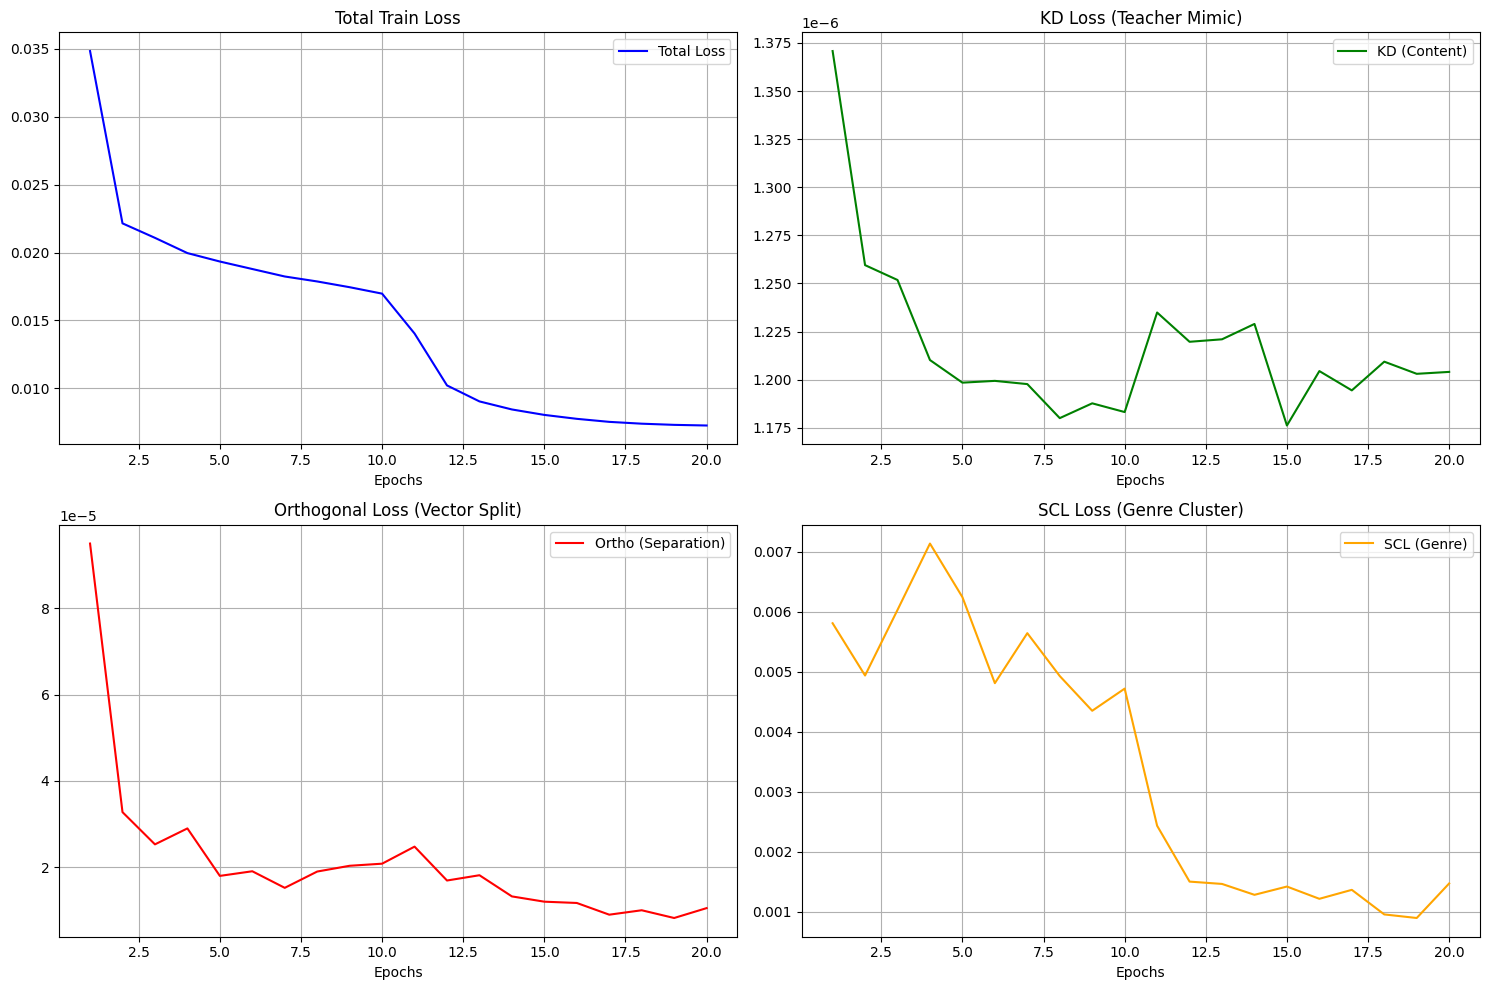

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 그리기
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(15, 10))

# 1. Total Loss & LR
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history["train_loss"], 'b-', label='Total Loss')
plt.title('Total Train Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

# 2. KD Loss (내용 학습)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, history["loss_kd"], 'g-', label='KD (Content)')
plt.title('KD Loss (Teacher Mimic)')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

# 3. Orthogonal Loss (분리 능력) - ★ 제일 중요!
plt.subplot(2, 2, 3)
plt.plot(epochs_range, history["loss_orth"], 'r-', label='Ortho (Separation)')
plt.title('Orthogonal Loss (Vector Split)')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

# 4. SCL Loss (장르 학습)
plt.subplot(2, 2, 4)
plt.plot(epochs_range, history["loss_scl"], 'orange', label='SCL (Genre)')
plt.title('SCL Loss (Genre Cluster)')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()